In [47]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, accuracy_score
from sklearn.decomposition import PCA

from utils import load_mnist, load_fashion_mnist
from utils import train_autoencoder, train_dec, train_idec

from utils import plot_ae_reconstructions, plot_all_reconstructions, plot_dec_centers

from models import Autoencoder, DEC, IDEC
import umap

In [48]:
input_dim = 64
latent_dim = 10
n_clusters = 10
pretrain_epochs = 10
finetune_epochs = 10
learning_rate = 0.01
gamma = 0.01,

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [49]:
# data, labels = load_digits(return_X_y=True)
# scaler = MinMaxScaler()
# data = scaler.fit_transform(data)
#
# tensor_x = torch.Tensor(data).to(device)
#
# indices = torch.arange(len(tensor_x)).to(device)
# dataset = TensorDataset(tensor_x, indices)
# train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [52]:
train_dataset, test_data = load_mnist()

# We flatten to (N, 784) and scale to [0, 1]
data = train_dataset.data.float() / 255.0
data = data.view(-1, 784)

labels = train_dataset.targets.numpy()
tensor_x = data.to(device)

# Create dataset with indices to map each batch to a full P distribution
# This allows us to compute P globally but train in batches
indices = torch.arange(len(tensor_x)).to(device)
dataset = TensorDataset(tensor_x, indices)
train_loader = DataLoader(dataset, batch_size=256, shuffle=True)

# Autoencoder Training

In [53]:
ae = Autoencoder(input_dim, latent_dim).to(device)

ae_optimizer = optim.Adam(ae.parameters(), lr=1e-3)
mse_loss = nn.MSELoss()

### Uncomment the lines below for custom training

In [54]:
# img_indices = [50563, 10910, 57965]
# ae_losses, images = train_autoencoder(
#     ae,
#     train_loader,
#     ae_optimizer,
#     mse_loss,
#     epochs=10,
#     image_indices=img_indices,
# )

In [55]:
# checkpoint = {
#     "model_state": ae.state_dict(),
#     "losses": ae_losses,
#     "images": images
# }
#
# torch.save(ae.state_dict(), "../checkpoints/autoencoder_mnist_param.pth")
# torch.save(checkpoint, "../checkpoints/autoencoder_mnist_full.pth")

### Load pretrained Autoencoder

In [65]:
ae = Autoencoder()

checkpoint = torch.load("../checkpoints/autoencoder_mnist_full.pth", map_location="cpu")
ae.load_state_dict(checkpoint["model_state"])
ae_losses = checkpoint["losses"]
images = checkpoint["images"]

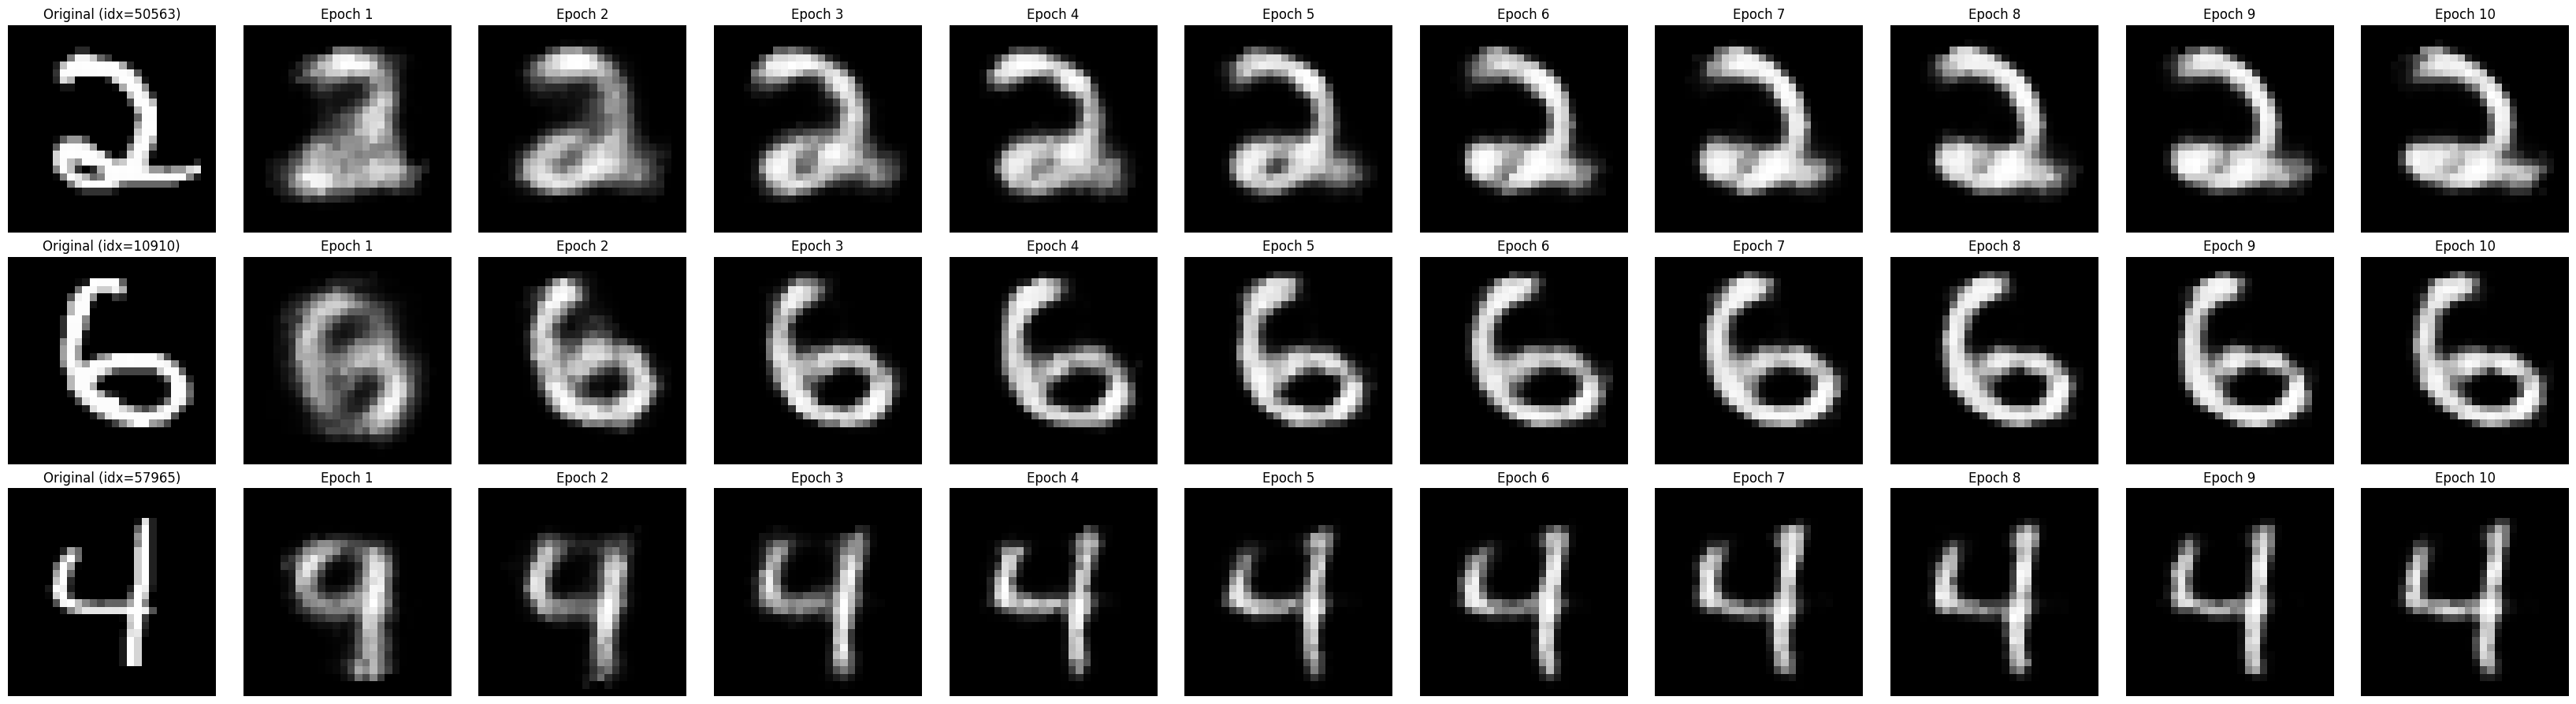

In [66]:
plot_all_reconstructions(images)

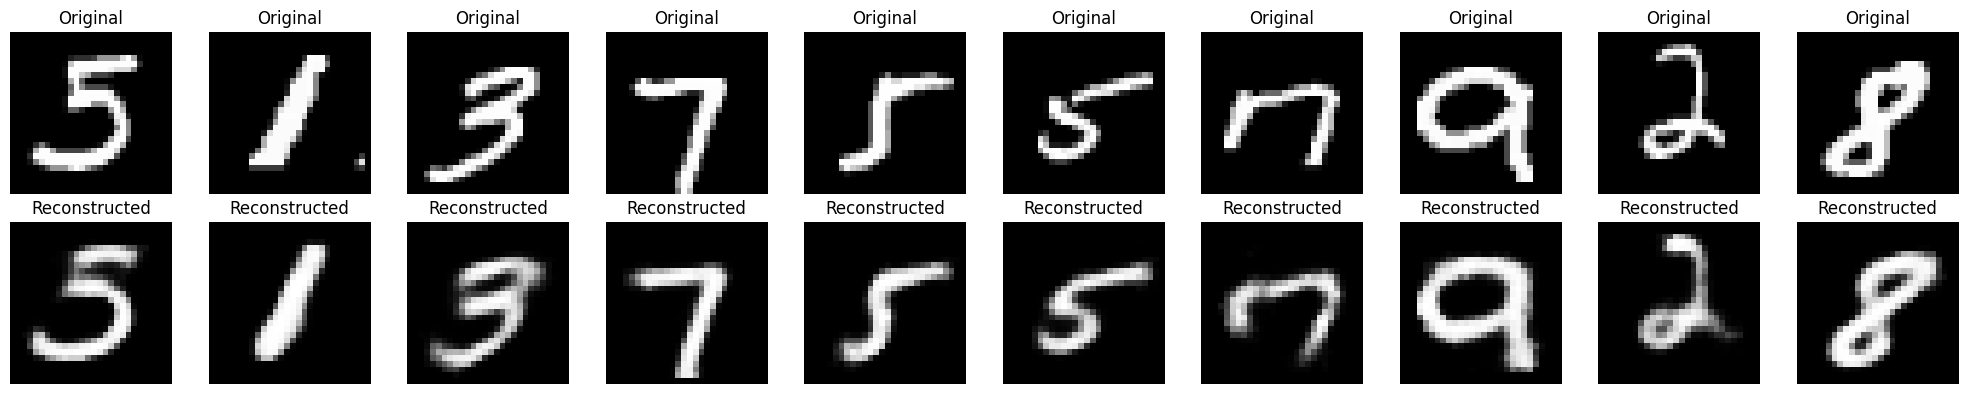

In [67]:
plot_ae_reconstructions(ae, train_dataset, device)

# IDEC Training

In [68]:
idec = IDEC(ae, n_clusters, latent_dim).to(device)
# dec.initialize_centers(train_loader, device)

idec_optimizer = optim.SGD(idec.parameters(), lr=learning_rate, momentum=0.9)
kl_loss_fn = nn.KLDivLoss(reduction='batchmean')
mse_loss_fn = nn.MSELoss()

### Uncomment the lines below for custom training


In [69]:
losses = train_idec(
    idec,
    train_loader,
    idec_optimizer,
    kl_loss_fn,
    mse_loss_fn,
    tensor_x,
    epochs=10,
    gamma=0.01,
    device=device,
)

Epoch 1/10: average kl loss = 0.0667 mse loss = 0.0283
Epoch 2/10: average kl loss = 0.1592 mse loss = 0.0451
Epoch 3/10: average kl loss = 0.1954 mse loss = 0.0540
Epoch 4/10: average kl loss = 0.1978 mse loss = 0.0584
Epoch 5/10: average kl loss = 0.1926 mse loss = 0.0610
Epoch 6/10: average kl loss = 0.1885 mse loss = 0.0626
Epoch 7/10: average kl loss = 0.1813 mse loss = 0.0637
Epoch 8/10: average kl loss = 0.1757 mse loss = 0.0645
Epoch 9/10: average kl loss = 0.1695 mse loss = 0.0651
Epoch 10/10: average kl loss = 0.1637 mse loss = 0.0655


In [70]:
torch.save(idec.state_dict(), "../checkpoints/idec_mnist_param.pth")

### Load pretrained Autoencoder

In [13]:
idec.load_state_dict(torch.load("../checkpoints/idec_mnist_param.pth"))
idec.eval()

DEC(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=2000, bias=True)
    (5): ReLU()
    (6): Linear(in_features=2000, out_features=10, bias=True)
  )
)

# Model evaluation

In [71]:
idec.eval()
with torch.no_grad():
    q_final, full_z_np, full_recon = idec(tensor_x)
    full_z_np = full_z_np.cpu().numpy()
    full_recon = full_recon.cpu().numpy()
    pred_labels = torch.argmax(q_final, dim=1).cpu().numpy()

ari = adjusted_rand_score(labels, pred_labels)
nmi = normalized_mutual_info_score(labels, pred_labels)

print(f"Adjusted Rand Score: {ari:.4f}")
print(f"Normalized Mutual Information : {nmi:.4f}")
print(f"Predicted Cluster Counts: {np.bincount(pred_labels)}")

Adjusted Rand Score: 0.6512
Normalized Mutual Information : 0.7390
Predicted Cluster Counts: [7979 3659 9284 6019 3593 5854 6169 5711 4056 7676]


# Plot results

In [73]:
plot_dec_centers(idec, ae)

ValueError: cannot reshape array of size 7840 into shape (8,8)

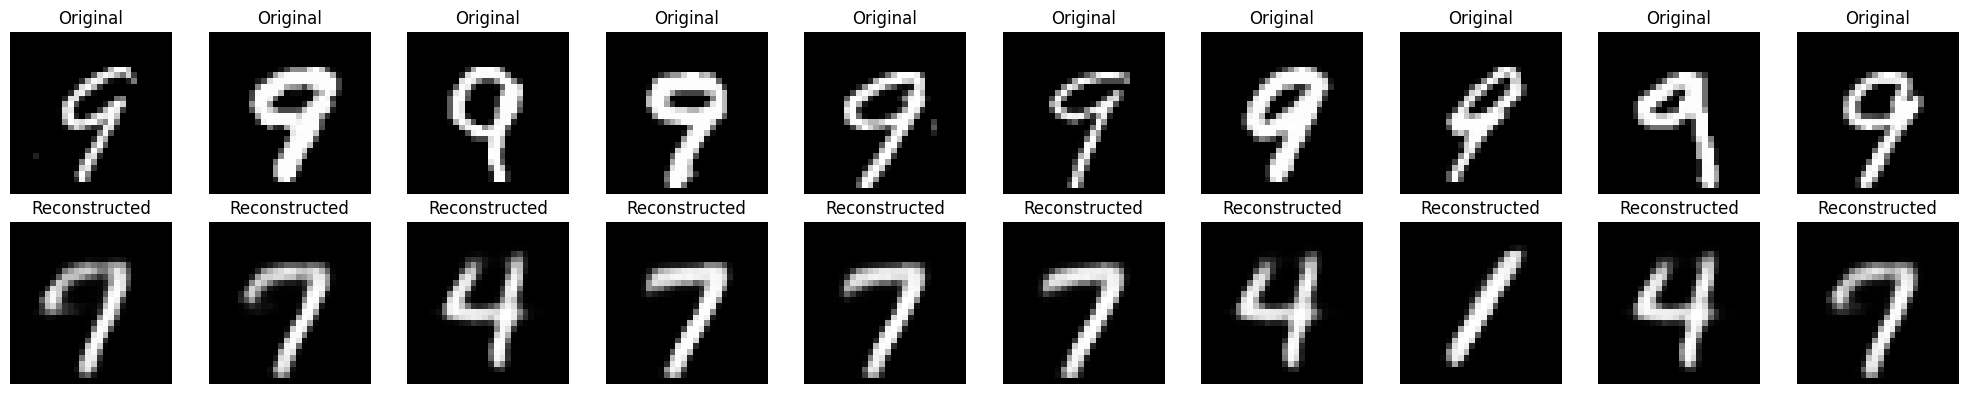

In [74]:
indices = []

while True:
    idx = torch.randint(len(train_dataset), size=(1,)).item()

    img, label = train_dataset[idx]
    if label == 9:
        indices.append(idx)

    if len(indices) == 10:
        break

plot_ae_reconstructions(ae, train_dataset, indices=indices)

In [75]:
reducer = umap.UMAP()

In [76]:
embedding = reducer.fit_transform(data)

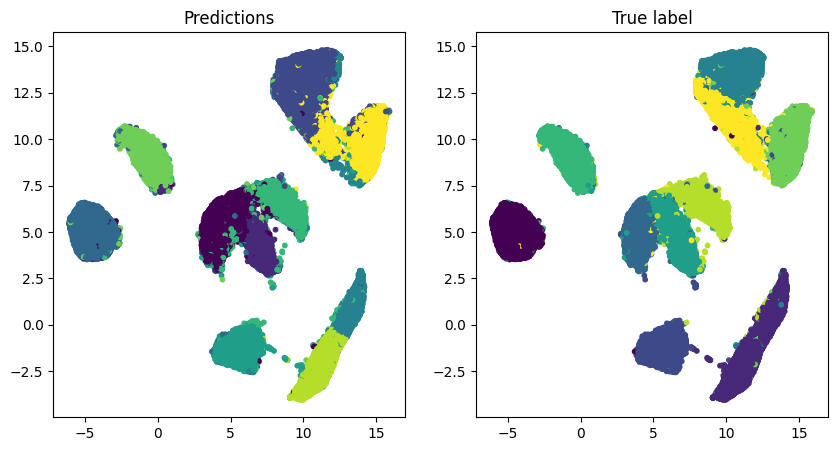

In [77]:
'''----- Umap form the input space -----'''
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].set_title('Predictions')
ax[0].scatter(embedding[:, 0], embedding[:, 1], c=pred_labels, s=10)

ax[1].set_title('True label')
ax[1].scatter(embedding[:, 0], embedding[:, 1], c=labels, s=10)

plt.show()

In [78]:
latent_embedding = reducer.fit_transform(full_z_np)

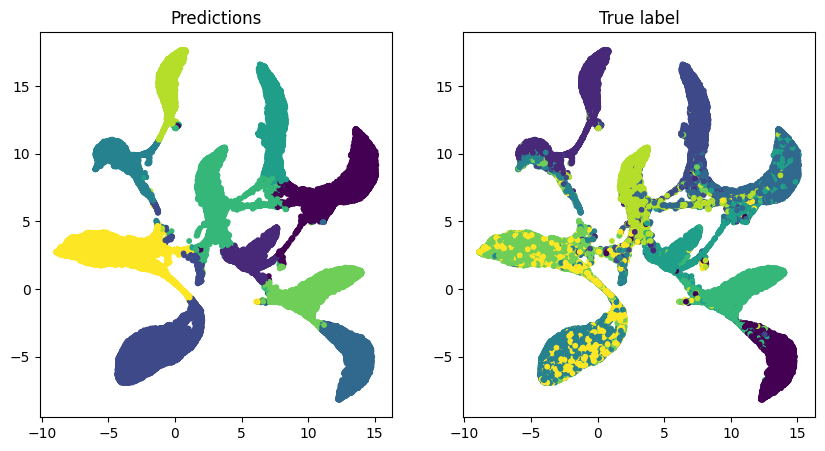

In [79]:
'''----- Umap form the latent space -----'''
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].set_title('Predictions')
ax[0].scatter(latent_embedding[:, 0], latent_embedding[:, 1], c=pred_labels, s=10)

ax[1].set_title('True label')
ax[1].scatter(latent_embedding[:, 0], latent_embedding[:, 1], c=labels, s=10)

plt.show()

In [80]:
pca = PCA(n_components=2)
transformed_data = pca.fit_transform(data)

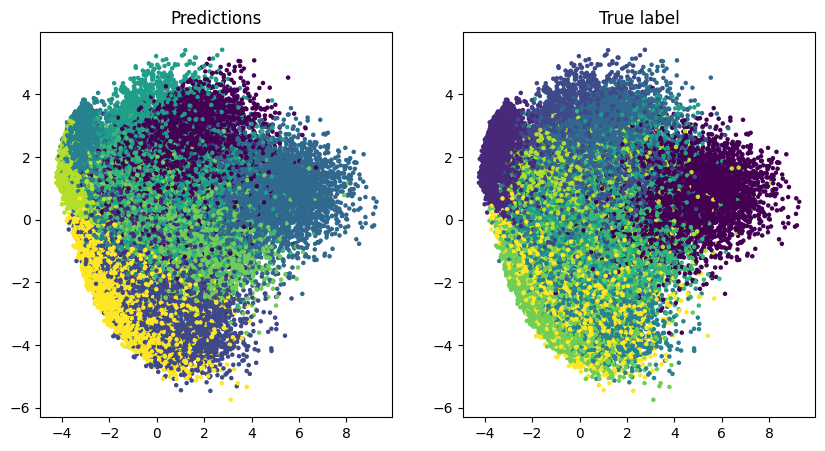

In [81]:
'''----- PCA form the input space -----'''
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].set_title('Predictions')
ax[0].scatter(transformed_data[:, 0], transformed_data[:, 1], c=pred_labels, s=5)

ax[1].set_title('True label')
ax[1].scatter(transformed_data[:, 0], transformed_data[:, 1], c=labels, s=5)

plt.show()

In [82]:
pca = PCA(n_components=2)
transformed_data = pca.fit_transform(full_z_np)

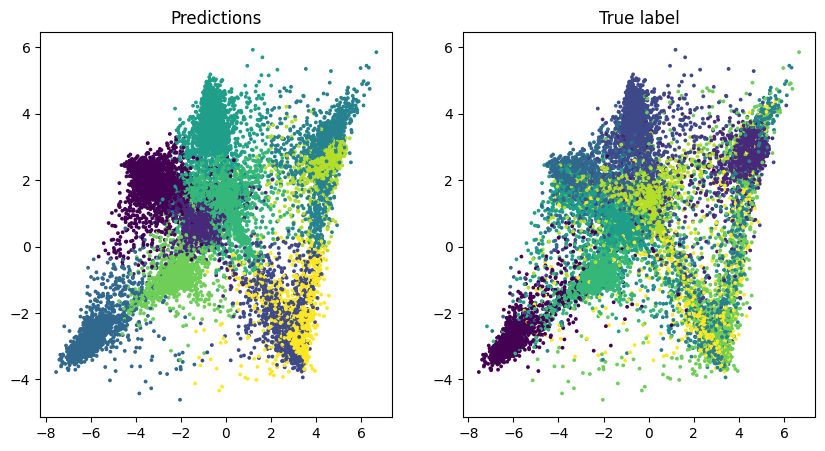

In [83]:
'''----- PCA form the latent space -----'''
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].set_title('Predictions')
ax[0].scatter(transformed_data[:, 0], transformed_data[:, 1], c=pred_labels, s=3)

ax[1].set_title('True label')
ax[1].scatter(transformed_data[:, 0], transformed_data[:, 1], c=labels, s=3)

plt.show()